# Part2 Writing a renderer

## Q1

In [64]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from math import atan, sin, cos
# you are only allowed to import numpy
# for further math calculations!!
import numpy as np
from numpy.linalg import multi_dot

- Define a 3D-cube as a numpy array with `8 corners` in 3D space centered on [0,0,0] and edge length 2. 
    - corners = [[1,1,1], [1,1,-1], [1,-1,1], [-1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], [-1,-1,-1]]
- Nx2-array that specifies which of the 8 corners are
connected. (`12 edges`)
    - edges = [(0,1),(0,2),(1,3),…]

### Creating 3D Cube

In [2]:
def create_3dcube(x,y,z,d):
    '''
    x, y, z are coordinates, d is the length of the edge
    '''
    node = [[x-d, y-d, z-d],
            [x-d, y-d, z+d],
            [x-d, y+d, z-d],
            [x-d, y+d, z+d],
            [x+d, y-d, z-d],
            [x+d, y-d, z+d],
            [x+d, y+d, z-d],
            [x+d, y+d, z+d]]

    edge = [[0,1],[1,3],[3,2],[2,0],
            [4,5],[5,7],[7,6],[6,4],
            [0,4],[1,5],[2,6],[3,7]]
    
    return {'node':node, 'edge':edge}

### Visualizing 3D Cube

In [3]:
def show_3d(vertices, edges):
    '''
    functions require non-homogenous
    '''
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca(projection='3d')
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    plt.show()

In [4]:
obj = create_3dcube(0,0,0,1)

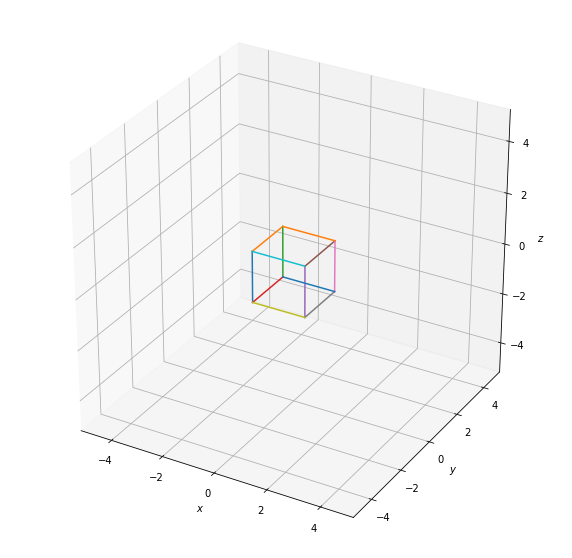

In [5]:
show_3d(obj['node'],obj['edge'])

### Rotation

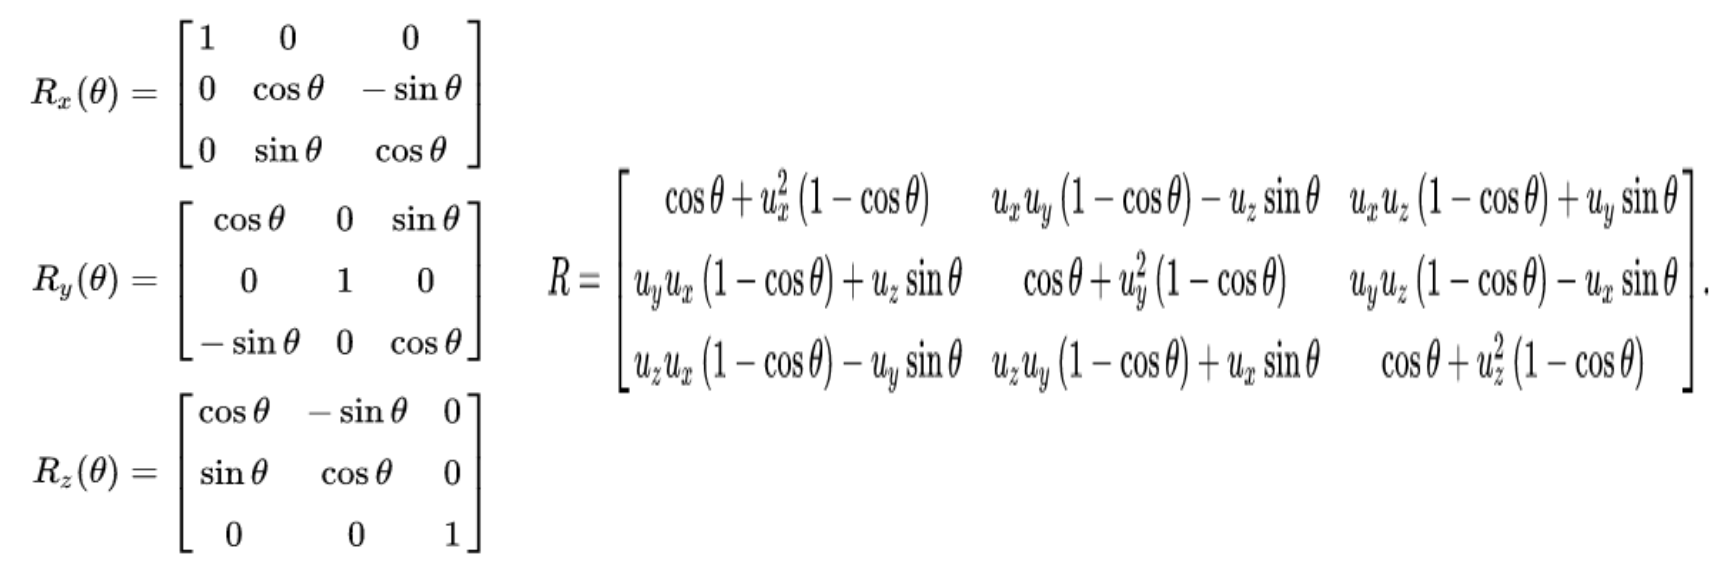

In [66]:
def rotate(orientation):
    '''
    target_vector : vector that we want to rotate
    '''
    # define theta
    x_theta = orientation[0]
    y_theta = orientation[1]
    z_theta = orientation[2]
    
    # define axis
    x_axis = [1,0,0]
    y_axis = [0,1,0]
    z_axis = [0,0,1]

    # define rotation matrix
    def rotate_matrix(axis, theta):
        ux, uy, uz = axis
        sine = sin(theta)
        cose = cos(theta)

        rotate_matrix = np.array([[cose+np.power(uz,2)*(1-cose), ux*uy*(1-cose)-uz*sine, ux*uz*(1-cose)+uy*sine],
                                 [uy*ux*(1-cose)+uz*sine, cose+np.power(uy,2)*(1-cose), uy*uz*(1-cose)-ux*sine],
                                 [uz*ux*(1-cose)-uy*sine, uz*uy*(1-cose)+ux*sine, cose+np.power(uz,2)*(1-cose)]])
        
        return rotate_matrix
    
    x_rotate_matrix = rotate_matrix(x_axis, x_theta)
    y_rotate_matrix = rotate_matrix(y_axis, y_theta)
    z_rotate_matrix = rotate_matrix(z_axis, z_theta)

    # rotate first around the x-axis, y-axis, and z-axis 
    zyx_rotate_matrix = multi_dot([z_rotate_matrix, y_rotate_matrix, x_rotate_matrix])

    return zyx_rotate_matrix

### Convert Eculidian Coordinate to Homogenuous Coordinate (Vice Versa)

In [7]:
def to_homogenuous(points):
    '''
    turns an array of euclidean coordinates into homogenous coordinates by simply adding a 1 as another dimension.
    '''
    points = np.insert(points, len(points), 1)
    return points

In [8]:
def from_homogenuous(points):
    '''
    turns an array of homogenous coordinates into euclidean coordinates by diving and excluding the last dimension value.
    '''
    points = np.divide(points[:-1],points[-1])
    return points

### Translation

In [9]:
def translate(target_vector):
    '''
    translate world coordinate to camera coordinate
    '''
    target_vector = np.insert(np.negative(target_vector), len(target_vector), 1) # change to homogenuous coordinate

    translate_matrix = np.append(np.identity(4)[:,:3], np.transpose([target_vector]), axis=-1) # put -c(postition) in the last column

    return translate_matrix

### Get Extrinsic Matrix

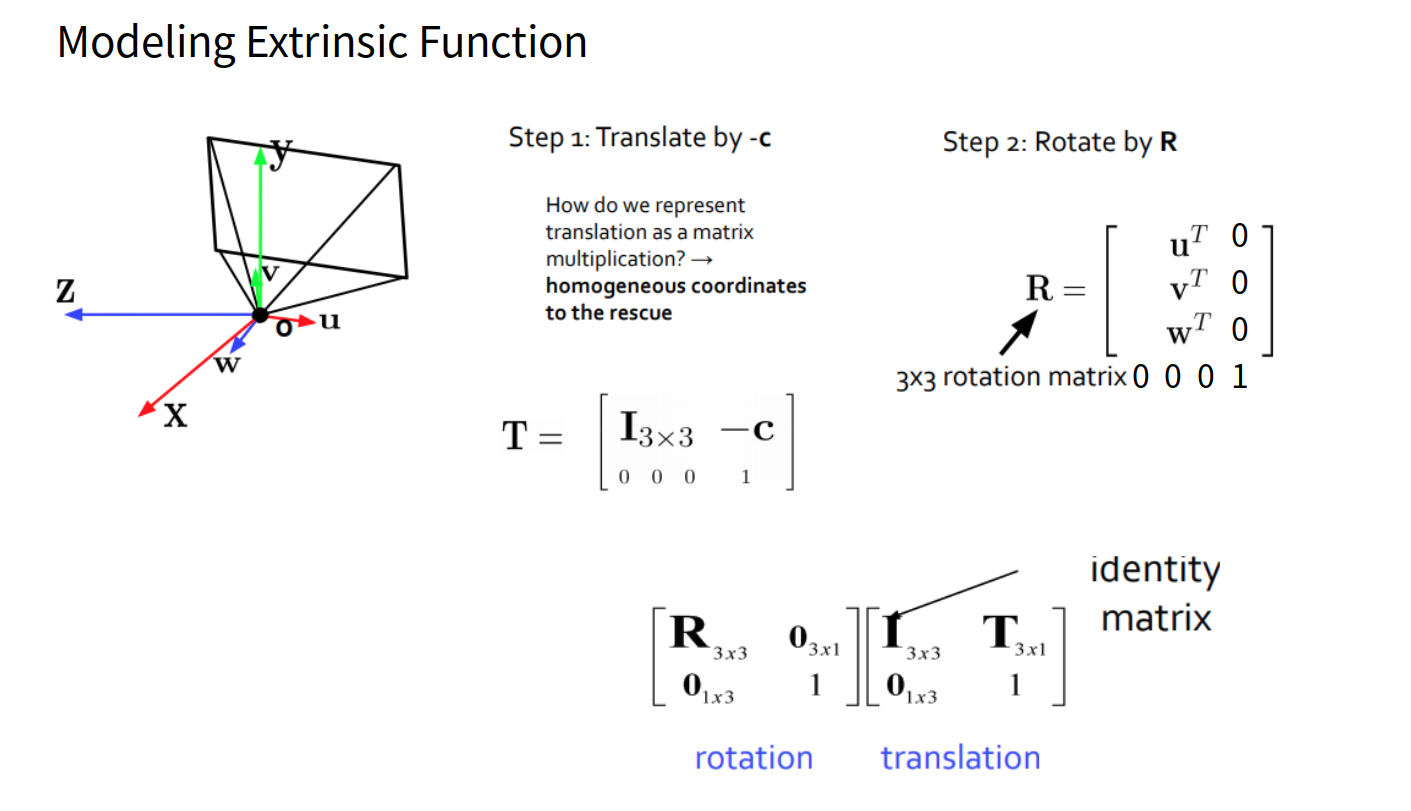

In [67]:
def get_extrinsic_matrix(position, orientation): # added extra theta variable for various experiments
    # get rotation matrix
    r_matrix = rotate(orientation) 
    r_matrix = np.append(r_matrix, [[0,0,0,]], axis=0) 
    r_matrix = np.append(r_matrix, np.transpose([[0,0,0,1]]), axis=-1) # add row&column to make 4x4 matrix
    
    # get translation matrix
    t_matrix = translate(position)
    
    # get extrinsic_matrix rotate and translate
    extrinsic_matrix = np.dot(t_matrix, r_matrix)
    
    return extrinsic_matrix

### Test Extrinsic model

In [82]:
camera_position = [0, 0, -3]
camera_orientation = [0, 0.1, 0]

extrinsic_matrix = get_extrinsic_matrix(camera_position, camera_orientation)

print('extrinsic_matrix : \n', extrinsic_matrix)

ext_coord = []
for i in range(len(obj['node'])):
    ext_transform = list(from_homogenuous(np.matmul(extrinsic_matrix,to_homogenuous(obj['node'][i]))))
    ext_coord.append(ext_transform)

ext_coord = np.array(ext_coord)

extrinsic_matrix : 
 [[ 0.99500417  0.          0.09983342  0.        ]
 [ 0.          1.          0.          0.        ]
 [-0.09983342  0.          0.99500417  3.        ]
 [ 0.          0.          0.          1.        ]]


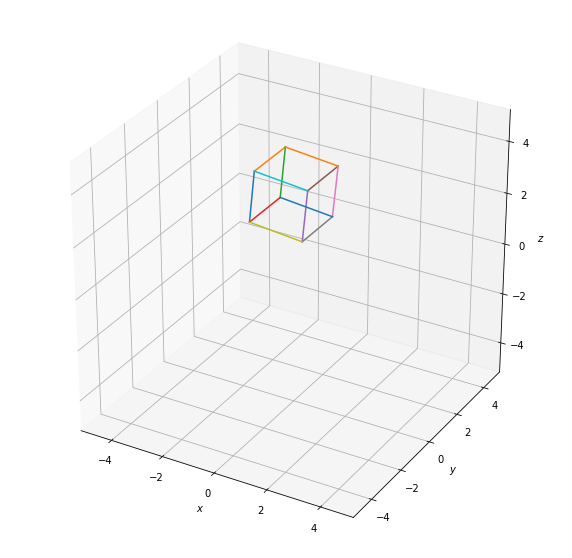

In [83]:
show_3d(ext_coord, obj['edge'])

### Get intrinsic matrix

In [84]:
def get_intrinsic_matrix(f,s):
    # define intrinsics
    intrinsics = np.identity(3)
    intrinsics[0][0] = f
    intrinsics[1][1] = f
    intrinsics[0][2] = s[0]
    intrinsics[1][2] = s[1]

    # projection matrix
    projection = np.identity(4)[:3,:]

    # define intrinsic matrix
    intrinsic_matrix = np.matmul(intrinsics, projection)
    
    return intrinsic_matrix

### Test Intrinsic Matrix with Extrinsic Output from above

In [85]:
f = 0.6
s = (0.5,0.5)

intrinsic_matrix = get_intrinsic_matrix(f,s)

print('intrinsic_matrix : \n', intrinsic_matrix)

int_coord = []
for i in range(len(ext_coord)):
    int_transform = list(from_homogenuous(np.matmul(intrinsic_matrix, to_homogenuous(ext_coord[i]))))
    int_coord.append(int_transform)
    
int_coord = np.array(int_coord)

intrinsic_matrix : 
 [[0.6 0.  0.5 0. ]
 [0.  0.6 0.5 0. ]
 [0.  0.  1.  0. ]]


### Visualizing 2D Projection

In [87]:
def show_2d(vertices, edges, size):
    '''
    functions require non-homogenous
    '''
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca()
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
            [p1[1], p2[1]])
    ax.set_xlim(0, size[0])
    ax.set_ylim(0, size[1])
    plt.show()

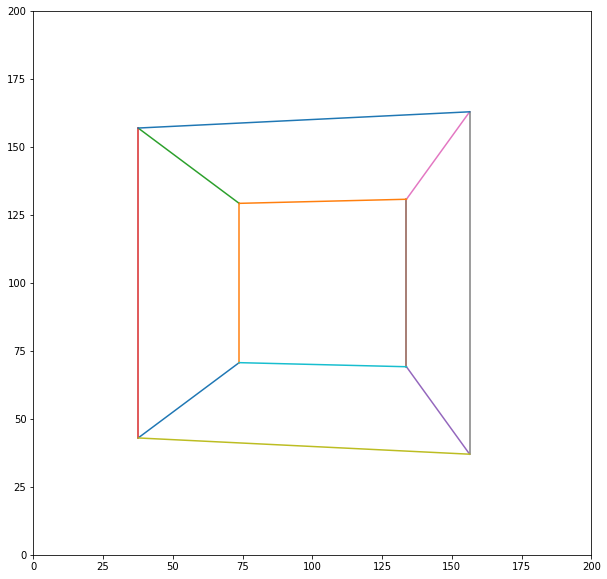

In [88]:
show_2d(int_coord * 200, obj['edge'], (200,200))

### Concate all function together using slider

In [91]:
def camera_coordinate_transformation(obj, camera_position, camera_orientation, f, s):
    # get extrinsic matrix
    extrinsic_matrix = get_extrinsic_matrix(camera_position, camera_orientation)

    # get extrinsic coordinates
    ext_coord = []
    for i in range(len(obj['node'])):
        ext_transform = list(from_homogenuous(np.matmul(extrinsic_matrix,to_homogenuous(obj['node'][i]))))
        ext_coord.append(ext_transform)
    
    ext_coord = np.array(ext_coord)

    # get intrinsic matrix
    intrinsic_matrix = get_intrinsic_matrix(f,s)

    # get intrinsic coordinates
    int_coord = []

    for i in range(len(ext_coord)):
        int_transform = list(from_homogenuous(np.matmul(intrinsic_matrix, to_homogenuous(ext_coord[i]))))
        int_coord.append(int_transform)
        
    int_coord = np.array(int_coord)

    # plotting (configured few details from original function)
    def show_3d(ax, vertices, edges):
        for edge in edges:
            p1 = vertices[edge[0]]
            p2 = vertices[edge[1]]
            ax.plot([p1[0], p2[0]],
                    [p1[1], p2[1]],
                    [p1[2], p2[2]])
            ax.scatter(camera_position[0], camera_position[1], camera_position[2])
            ax.text(camera_position[0], camera_position[1], camera_position[2], "Camera")
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')
        ax.set_ylim(-5, 5)
        ax.set_xlim(-5, 5)
        ax.set_zlim(-5, 5)
    
    def show_2d(ax, vertices, edges, size):
        '''
        functions require non-homogenous
        '''
        for edge in edges:
            p1 = vertices[edge[0]]
            p2 = vertices[edge[1]]
            ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]])
        ax.set_xlim(0, size[0])
        ax.set_ylim(0, size[1])

    fig = plt.figure(figsize = (20,10))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2)

    show_3d(ax1, ext_coord, obj['edge'])
    show_2d(ax2, int_coord*200, obj['edge'], (200, 200))
    plt.show()

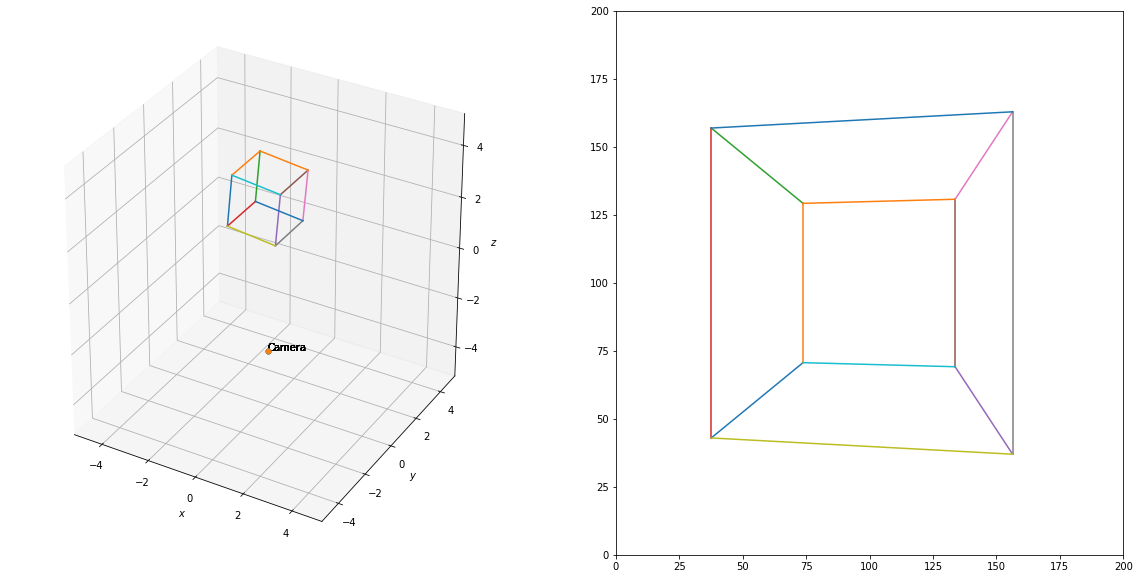

In [92]:
# define object
obj = create_3dcube(0,0,0,1)

# define camera position & orientation
camera_position = [0, 0, -3] # position of camera
camera_orientation = [0, 0.1, 0] # orientation of camera

# define camera specs
f = 0.6 # focal length
s = (0.5,0.5) # pixel size

camera_coordinate_transformation(obj, camera_position, camera_orientation, f, s)

## Q2 (Bonus)

Insert code that shows an open tube of similar proportions.

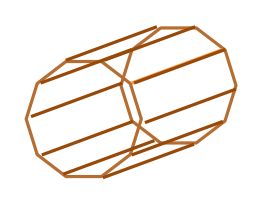

In [ ]:
import math

n = 10 # n point
r = 5 # radius
h = 10 # height 

# define coord
def get_points_poly(r, n, h, top):
    coord = []

    for i in range(n):
        X = r * math.cos(2 * math.pi * i / n)
        if top == 1:
            Y = h/2
        elif top == 0:
            Y = -h/2
        Z =  r* math.sin(2 * math.pi * i / n)
        tmp_coord = [X, Y, Z]
        coord.append(tmp_coord)

    return coord

# define edges
def get_edges_poly(n):
    edge = []

    for i in range(n):
        start = i
        next = i+1
        tmp_edge = [start, next]
        edge.append(tmp_edge)

    edge[-1][-1] = 0

    return edge

poly_coord_top = get_points_poly(r, n, h, 1)
poly_coord_bot = get_points_poly(r, n, h, 0)

poly_edge = get_edges_poly(n)

print(poly_coord_top)
print(poly_coord_bot)
print(poly_edge)

[[5.0, 5.0, 0.0], [4.045084971874737, 5.0, 2.938926261462366], [1.5450849718747373, 5.0, 4.755282581475767], [-1.5450849718747368, 5.0, 4.755282581475768], [-4.045084971874736, 5.0, 2.9389262614623664], [-5.0, 5.0, 6.123233995736766e-16], [-4.045084971874738, 5.0, -2.938926261462365], [-1.5450849718747377, 5.0, -4.755282581475767], [1.5450849718747361, 5.0, -4.755282581475768], [4.045084971874736, 5.0, -2.938926261462367]]
[[5.0, -5.0, 0.0], [4.045084971874737, -5.0, 2.938926261462366], [1.5450849718747373, -5.0, 4.755282581475767], [-1.5450849718747368, -5.0, 4.755282581475768], [-4.045084971874736, -5.0, 2.9389262614623664], [-5.0, -5.0, 6.123233995736766e-16], [-4.045084971874738, -5.0, -2.938926261462365], [-1.5450849718747377, -5.0, -4.755282581475767], [1.5450849718747361, -5.0, -4.755282581475768], [4.045084971874736, -5.0, -2.938926261462367]]
[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 0]]


### Plot 2D

In [ ]:
def show_poly_2d(poly_coord, poly_edge):
    '''
    functions require non-homogenous
    '''
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca()
    for edge in poly_edge:
        p1 = poly_coord[edge[0]]
        p2 = poly_coord[edge[1]]
        ax.plot([p1[0], p2[0]],
            [p1[1], p2[1]])
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    plt.show()

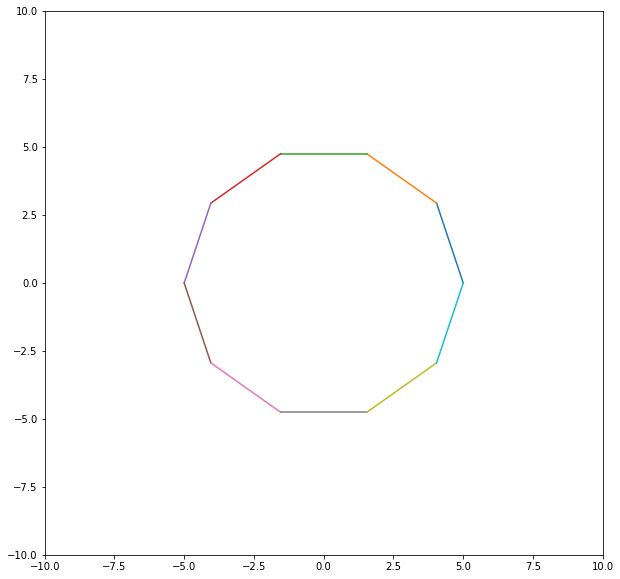

In [ ]:
poly_coord_top = np.array(poly_coord_top)
poly_coord=np.transpose(np.transpose(poly_coord_top)[[0,2]])
show_poly_2d(poly_coord,poly_edge)

### Plot 3D

In [ ]:
def show_poly_3d(poly_coord_top, poly_coord_bot, poly_edge):
    '''
    functions require non-homogenous
    '''
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca(projection='3d')

    for edge in poly_edge:
        p1 = poly_coord_top[edge[0]] 
        p2 = poly_coord_top[edge[1]]
        
        p3 = poly_coord_bot[edge[0]] 
        p4 = poly_coord_bot[edge[1]]

        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]], color='brown') 
        
        ax.plot([p3[0], p4[0]],
                [p3[1], p4[1]],
                [p3[2], p4[2]], color='brown')
    
        ax.plot([p1[0], p3[0]],
                [p1[1], p3[1]],
                [p1[2], p3[2]], color='brown') 
            
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)
    ax.set_zlim(-10, 10)
    plt.show()

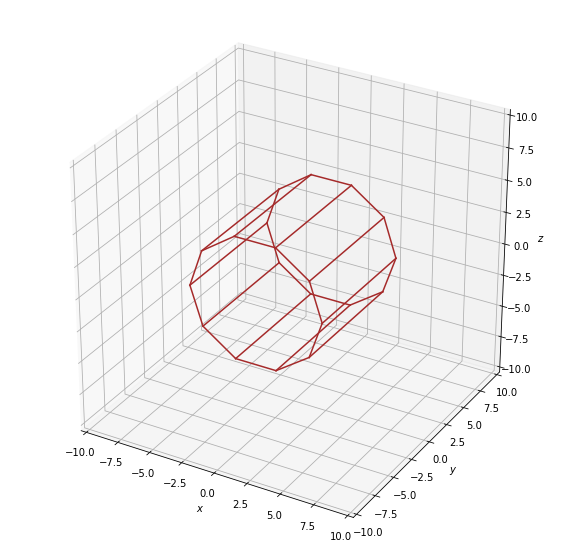

In [ ]:
show_poly_3d(poly_coord_top, poly_coord_bot, poly_edge)

### Concate all function together using slider

In [ ]:
import math

# Define overall function for drawing polynomial cylinder
def draw_poly_cyclinder(r, n, h):
    # define coord
    def get_points_poly(r, n, h, top):
        coord = []

        for i in range(n):
            X = r * math.cos(2 * math.pi * i / n)
            if top == 1:
                Y = h/2
            elif top == 0:
                Y = -h/2
            Z =  r* math.sin(2 * math.pi * i / n)
            tmp_coord = [X, Y, Z]
            coord.append(tmp_coord)

        return coord

    # define edges
    def get_edges_poly(n):
        edge = []

        for i in range(n):
            start = i
            next = i+1
            tmp_edge = [start, next]
            edge.append(tmp_edge)

        edge[-1][-1] = 0

        return edge
    
    def show_poly_3d(poly_coord_top, poly_coord_bot, poly_edge):
        '''
        functions require non-homogenous
        '''
        fig = plt.figure(figsize = (10,10))
        ax = fig.gca(projection='3d')

        for edge in poly_edge:
            p1 = poly_coord_top[edge[0]] 
            p2 = poly_coord_top[edge[1]]
            
            p3 = poly_coord_bot[edge[0]] 
            p4 = poly_coord_bot[edge[1]]
            
            # draw edeges for top of the cylinder
            ax.plot([p1[0], p2[0]],
                    [p1[1], p2[1]],
                    [p1[2], p2[2]], color='brown') 
            # draw edeges for bottom of the cylinder
            ax.plot([p3[0], p4[0]],
                    [p3[1], p4[1]],
                    [p3[2], p4[2]], color='brown')
            # draw edeges for side of the cylinder
            ax.plot([p1[0], p3[0]],
                    [p1[1], p3[1]],
                    [p1[2], p3[2]], color='brown') 
                
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)
        ax.set_zlim(-10, 10)
        plt.show()

    # define coordinates for the top side and bottom side
    poly_coord_top = get_points_poly(r, n, h, 1)
    poly_coord_bot = get_points_poly(r, n, h, 0)
    poly_edge = get_edges_poly(n)

    show_poly_3d(poly_coord_top, poly_coord_bot, poly_edge)

In [ ]:
# for extra visualization 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, FloatSlider, IntSlider
import matplotlib.pyplot as plt
%matplotlib inline

r = FloatSlider(value=5, min=1, max=10, step=0.1)
h = FloatSlider(value=10, min=1, max=20, step=0.1)
n = IntSlider(value=10, min=3, max=100, step=1)

interact(draw_poly_cyclinder, n=n, h=h, r=r)

interactive(children=(FloatSlider(value=5.0, description='r', max=10.0, min=1.0), IntSlider(value=10, descript…

<function __main__.draw_poly_cyclinder>